In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip


Importing the necessary Libraries.............

In [12]:
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

Reading the train and test data

In [13]:
train_data = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_data = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

Lets have a look at the train data

In [14]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Lets have a look at the test data

In [15]:
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


What is the shape of train data?(how many rows and columns?)

In [16]:
train_data.shape

(159571, 8)

Similarly, what is the shape of test data?

In [17]:
test_data.shape

(153164, 2)

Lets calculate some statistics of train data 

In [18]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Observation**: Mean is very low for all categories, hence most of the comments do not belong to any of these categories

Is there any null values in the train and test data?

In [19]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [20]:
test_data.isnull().sum()

id              0
comment_text    0
dtype: int64

In [21]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Lets check the count of each of these categories

In [22]:
train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis = 0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

**Observation:**
1. Out of the six categories,"toxic" leads the list followed by "obscene"

In [23]:
train_data['Comment_score'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis = 1)
train_data['Comment_score'] .value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: Comment_score, dtype: int64

Observation:

1. There are 143346 comments which doesnot belong to any of the categories
2. There are 6360 comments belong to only one category
3. There are 31 comments which are part of all categories

Now lets preprocess and featurize the "comments"..............

In [24]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
train_data['comment_text'].head(1).values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"],
      dtype=object)

In [27]:
def nlp_preprocessing(sentance, index, column):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    train_data.loc[index,column] = sentance.strip()

In [28]:
for index, row in tqdm(train_data.iterrows()):
    if type(row['comment_text']) is str:
        nlp_preprocessing(row['comment_text'], index, 'comment_text')
    else:
        print("there is no text description for id:",index)

159571it [36:44, 72.39it/s] 


In [29]:
train_data['comment_text'].head(1).values

array(['explanation edits made username hardcore metallica fan reverted not vandalisms closure gas voted new york dolls fac please not remove template talk page since retired'],
      dtype=object)

In [30]:
from collections import defaultdict
def extract_word(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['comment_text'].split():
            dictionary[word] +=1
    return dictionary

In [31]:
word_count = extract_word(train_data)

In [32]:
sorted(word_count.items(), key=lambda x: x[1], reverse=True)

[('not', 150408),
 ('article', 57478),
 ('page', 46330),
 ('wikipedia', 45887),
 ('talk', 36557),
 ('would', 36195),
 ('please', 29779),
 ('no', 29250),
 ('one', 29151),
 ('like', 27991),
 ('see', 21578),
 ('also', 20624),
 ('think', 20068),
 ('know', 19129),
 ('people', 18432),
 ('edit', 18260),
 ('use', 16688),
 ('articles', 16630),
 ('time', 15819),
 ('may', 15586),
 ('thanks', 13880),
 ('even', 13458),
 ('get', 13409),
 ('user', 13169),
 ('make', 12992),
 ('could', 12821),
 ('good', 12806),
 ('well', 12423),
 ('information', 12158),
 ('want', 11609),
 ('deletion', 11435),
 ('sources', 11353),
 ('way', 11246),
 ('name', 11212),
 ('first', 10967),
 ('help', 10719),
 ('pages', 10683),
 ('new', 10647),
 ('wp', 10606),
 ('image', 10448),
 ('editing', 10362),
 ('source', 10354),
 ('go', 10314),
 ('need', 10190),
 ('section', 10152),
 ('say', 10114),
 ('fuck', 10083),
 ('edits', 9979),
 ('thank', 9903),
 ('made', 9673),
 ('many', 9579),
 ('much', 9468),
 ('used', 9208),
 ('really', 9205),

Lets have a look at the most frequent words

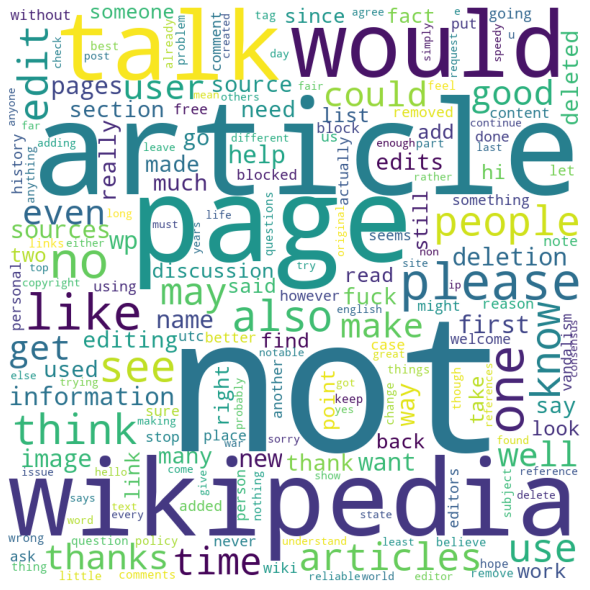

In [33]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(word_count) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [34]:
train_data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Comment_score
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man really not trying edit war guy constan...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,not make real suggestions improvement wondered...,0,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,0


Split the data in to train and test data. General scenario is 
1. Use train data for training as well as for cross validation(hyper parameter tuning) and test data for testing
2. Split data in to train, cross validation and test. Then use train data for training, cross validation for parameter tuning and test data for testing

Here i have done hyper parameter tuning with test data

In [35]:
X = train_data['comment_text']
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# split the data set into train and test
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**How to featurize "Comments?**
1. One hot Encoding
2. Response coding

**One hot Encoding**

In [36]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vector = CountVectorizer(min_df=3)
X_tr_onehotCoding = text_vector.fit_transform(X_tr)
# getting all the feature names (words)
X_tr_features= text_vector.get_feature_names()


X_tr_fea_counts = X_tr_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
X_tr_fea_dict = dict(zip(list(X_tr_features),X_tr_fea_counts))


print("Total number of unique words in train data :", len(X_tr_features))

Total number of unique words in train data : 40489


Lets see what are the most frequent words in each category

In [37]:
tr_all = pd.concat([X_tr,y_tr],axis = 1)
dict_list = []
# dict_list =[] contains 6 dictoinaries each corresponds to a class
for i in class_names :
    cls_comments = tr_all[tr_all[i]==1]
    # build a word dict based on the words in that class
    dict_list.append(extract_word(cls_comments))

In [38]:
total_dict = extract_word(tr_all)

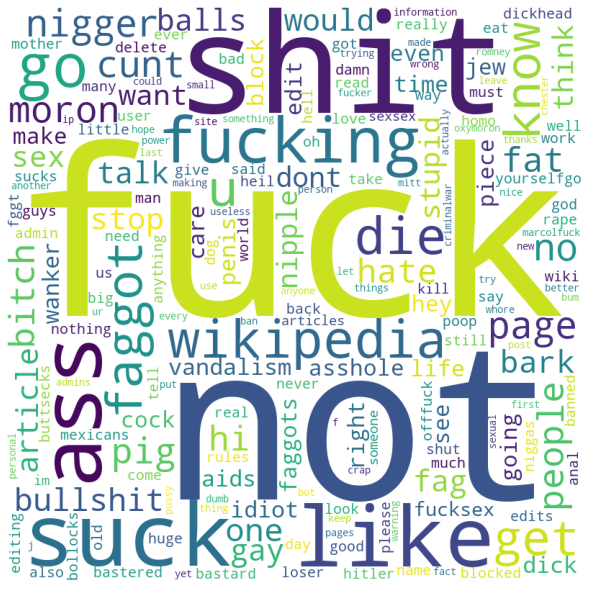

In [39]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[0]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

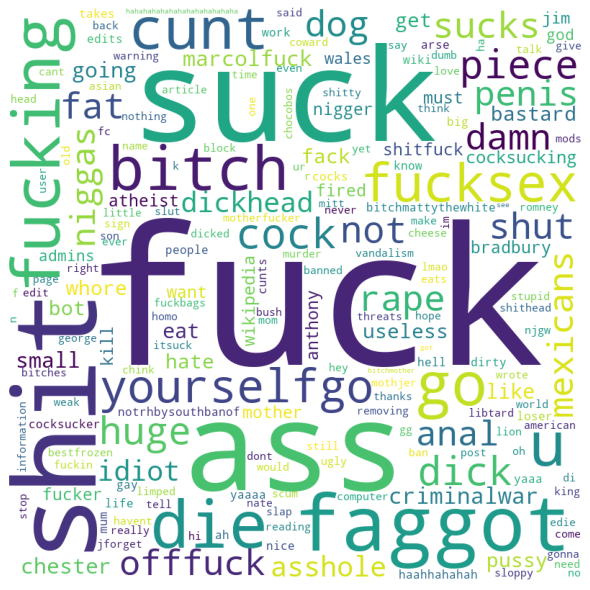

In [40]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[1]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

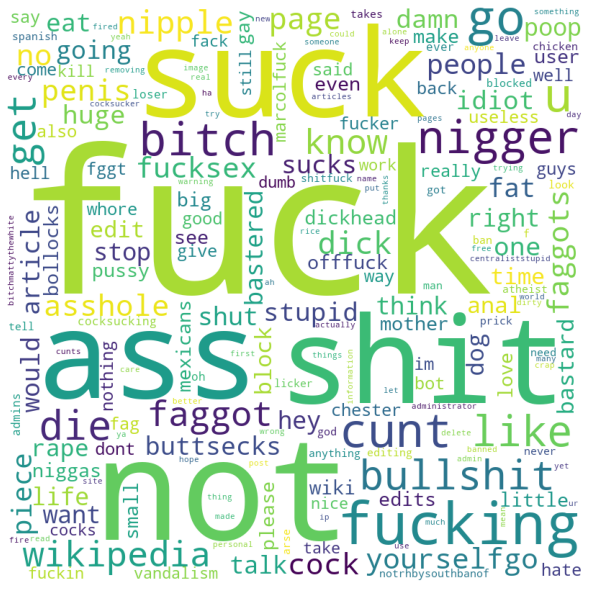

In [41]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[2]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

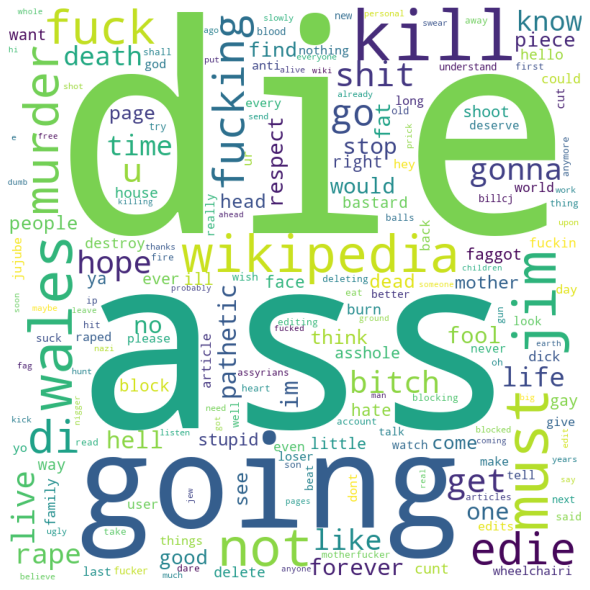

In [42]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[3]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

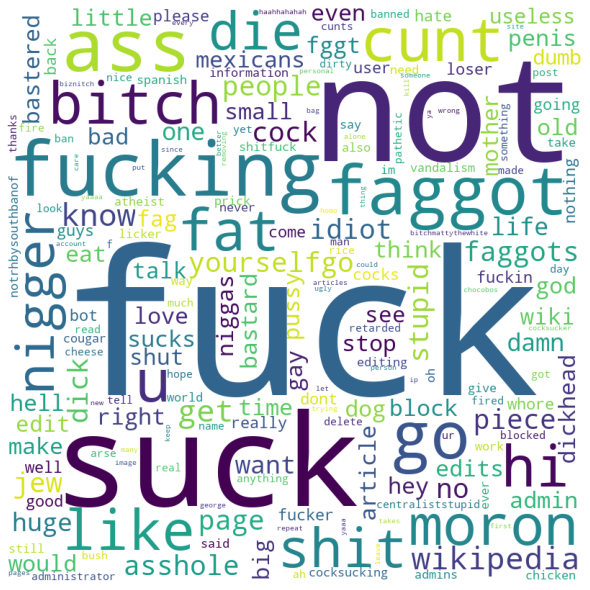

In [43]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[4]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

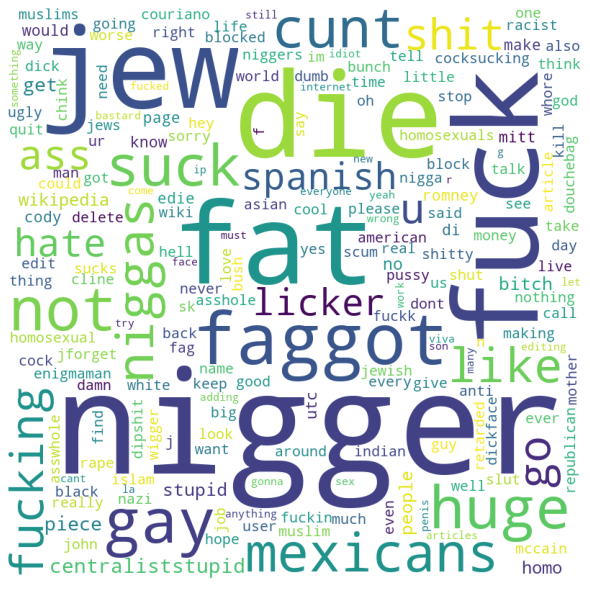

In [44]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict_list[5]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**Response Coding**

In [45]:
import math

def get_comment_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],6))
    for i in range(0,6):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['comment_text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/(len(row['comment_text'].split())+1))
            row_index += 1
    return text_feature_responseCoding

In [46]:
X_tr_responsecoding = get_comment_responsecoding(X_tr.to_frame())
X_test_responsecoding = get_comment_responsecoding(X_test.to_frame())

In [47]:
from sklearn.preprocessing import normalize

# normalize 
X_tr_onehotCoding = normalize(X_tr_onehotCoding, axis=0)
# we use the same vectorizer that was trained on train data
X_test_onehotCoding = text_vector.transform(X_test)

X_test_onehotCoding = normalize(X_test_onehotCoding, axis=0)

**For modelling lets use Logistic Regression with OneVsRest Classifier**

In [48]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.1, penalty='l2'), n_jobs=-1)
classifier.fit(X_tr_onehotCoding, y_tr)
predictions = classifier.predict_proba(X_test_onehotCoding)

In [49]:
roc_col1 = roc_auc_score(y_test.values[:,0],predictions[:,0])
roc_col2 = roc_auc_score(y_test.values[:,1],predictions[:,1])
roc_col3 = roc_auc_score(y_test.values[:,2],predictions[:,2])
roc_col4 = roc_auc_score(y_test.values[:,3],predictions[:,3])
roc_col5 = roc_auc_score(y_test.values[:,4],predictions[:,4])
roc_col6 = roc_auc_score(y_test.values[:,5],predictions[:,5])

In [50]:
roc_mean = (roc_col1+roc_col2+roc_col3+roc_col4+roc_col5+roc_col6)/6
roc_mean

0.7178553272425631

In [51]:
def model_tuning(X_train,X_test,y_train,y_test):
    alpha = [10 ** x for x in range(-6, 3)]
    reg = ['l1','l2']
    for i in alpha:
        for j in reg:
            classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha= i, penalty= j), n_jobs=-1)
            classifier.fit(X_train, y_train)
            predictions = classifier.predict_proba(X_test)
            roc_mean = roc_calc(y_test,predictions)
            print("for alpha =", i, "regularizer =", j , "ROC =", roc_mean)
    

In [52]:
def roc_calc(y_test,predictions):
    roc_col1 = roc_auc_score(y_test.values[:,0],predictions[:,0])
    roc_col2 = roc_auc_score(y_test.values[:,1],predictions[:,1])
    roc_col3 = roc_auc_score(y_test.values[:,2],predictions[:,2])
    roc_col4 = roc_auc_score(y_test.values[:,3],predictions[:,3])
    roc_col5 = roc_auc_score(y_test.values[:,4],predictions[:,4])
    roc_col6 = roc_auc_score(y_test.values[:,5],predictions[:,5])
    roc_mean = (roc_col1+roc_col2+roc_col3+roc_col4+roc_col5+roc_col6)/6
    return roc_mean

In [53]:
model_tuning(X_tr_responsecoding,X_test_responsecoding,y_tr,y_test)

for alpha = 1e-06 regularizer = l1 ROC = 0.9307919653907031
for alpha = 1e-06 regularizer = l2 ROC = 0.9322159355213678
for alpha = 1e-05 regularizer = l1 ROC = 0.9319331256018678
for alpha = 1e-05 regularizer = l2 ROC = 0.9311860271426919
for alpha = 0.0001 regularizer = l1 ROC = 0.9300966076426341
for alpha = 0.0001 regularizer = l2 ROC = 0.9261731342529748
for alpha = 0.001 regularizer = l1 ROC = 0.8503511872613583
for alpha = 0.001 regularizer = l2 ROC = 0.914498044389171
for alpha = 0.01 regularizer = l1 ROC = 0.5661762943596713
for alpha = 0.01 regularizer = l2 ROC = 0.9112105872782328
for alpha = 0.1 regularizer = l1 ROC = 0.5
for alpha = 0.1 regularizer = l2 ROC = 0.7747592773510416
for alpha = 1 regularizer = l1 ROC = 0.5
for alpha = 1 regularizer = l2 ROC = 0.48669793946998025
for alpha = 10 regularizer = l1 ROC = 0.5
for alpha = 10 regularizer = l2 ROC = 0.08996968027698025
for alpha = 100 regularizer = l1 ROC = 0.5
for alpha = 100 regularizer = l2 ROC = 0.08984802729595703


In [54]:
model_tuning(X_tr_onehotCoding,X_test_onehotCoding,y_tr,y_test)

for alpha = 1e-06 regularizer = l1 ROC = 0.9161462753704369
for alpha = 1e-06 regularizer = l2 ROC = 0.9172478751118925
for alpha = 1e-05 regularizer = l1 ROC = 0.8506768798746531
for alpha = 1e-05 regularizer = l2 ROC = 0.9272508615365576
for alpha = 0.0001 regularizer = l1 ROC = 0.4999614919556696
for alpha = 0.0001 regularizer = l2 ROC = 0.9233083622753808
for alpha = 0.001 regularizer = l1 ROC = 0.5
for alpha = 0.001 regularizer = l2 ROC = 0.8862818276430923
for alpha = 0.01 regularizer = l1 ROC = 0.5
for alpha = 0.01 regularizer = l2 ROC = 0.7781468700057018
for alpha = 0.1 regularizer = l1 ROC = 0.5
for alpha = 0.1 regularizer = l2 ROC = 0.7178127577639
for alpha = 1 regularizer = l1 ROC = 0.5
for alpha = 1 regularizer = l2 ROC = 0.7110953012983013
for alpha = 10 regularizer = l1 ROC = 0.5
for alpha = 10 regularizer = l2 ROC = 0.7104521278185789
for alpha = 100 regularizer = l1 ROC = 0.5
for alpha = 100 regularizer = l2 ROC = 0.7103670799755336


**Observation:**
1. Both response coding, one hot encoding gave good results
2. Response coding gave max value of .93
3. Best value for alpha is 1e-05 and regularization is L1

Build a final model with above values

In [55]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=1e-05, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr_responsecoding, y_tr)
predictions = classifier.predict_proba(X_test_responsecoding)

In [56]:
roc_col1 = roc_auc_score(y_test.values[:,0],predictions[:,0])
roc_col2 = roc_auc_score(y_test.values[:,1],predictions[:,1])
roc_col3 = roc_auc_score(y_test.values[:,2],predictions[:,2])
roc_col4 = roc_auc_score(y_test.values[:,3],predictions[:,3])
roc_col5 = roc_auc_score(y_test.values[:,4],predictions[:,4])
roc_col6 = roc_auc_score(y_test.values[:,5],predictions[:,5])

In [57]:
roc_mean = (roc_col1+roc_col2+roc_col3+roc_col4+roc_col5+roc_col6)/6
roc_mean

0.9319370786742839

Lets do the preprocessing and featurization for the test data

In [58]:
def nlp_preprocessing(sentance, index, column):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    test_data.loc[index,column] = sentance.strip()

In [59]:
for index, row in tqdm(test_data.iterrows()):
    if type(row['comment_text']) is str:
        nlp_preprocessing(row['comment_text'], index, 'comment_text')
    else:
        print("there is no text description for id:",index)

153164it [03:00, 848.63it/s]


In [60]:
test_data['comment_text'].head(1).values

array(['yo bitch ja rule succesful ever whats hating sad mofuckas bitch slap ur pethedic white faces get kiss ass guys sicken ja rule pride da music man dont diss shit nothin wrong bein like tupac brother fuckin white boys get things right next time'],
      dtype=object)

Apply Response Coding to comments

In [61]:
test_data_responsecoding = get_comment_responsecoding(test_data)

In [62]:
test_data_responsecoding

array([[0.17086037, 0.0498716 , 0.12159304, 0.02867649, 0.11145871,
        0.04445074],
       [0.07401834, 0.03121239, 0.0499819 , 0.02775061, 0.04685911,
        0.0299598 ],
       [0.12231093, 0.07263592, 0.10257164, 0.06892277, 0.10021793,
        0.07917148],
       ...,
       [0.05762578, 0.02297612, 0.04066659, 0.02053479, 0.0392135 ,
        0.02351944],
       [0.06672349, 0.01888753, 0.04225063, 0.01582164, 0.04044905,
        0.0233898 ],
       [0.11437943, 0.01348164, 0.06712477, 0.01048856, 0.05539326,
        0.01596445]])

In [63]:
submission = pd.DataFrame.from_dict({'id': test_data['id']})

Apply classifier to test data and do the prediction

In [64]:
mat = classifier.predict_proba(test_data_responsecoding)
submission = pd.concat([submission, pd.DataFrame(mat,columns = class_names)], axis=1)

In [65]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.440380,0.008851,0.215826,0.005266,0.143591,0.014851
1,0000247867823ef7,0.021406,0.003121,0.008710,0.002817,0.012411,0.005019
2,00013b17ad220c46,0.024194,0.003080,0.007062,0.003342,0.017667,0.007760
3,00017563c3f7919a,0.022040,0.003298,0.012656,0.002601,0.014498,0.004820
4,00017695ad8997eb,0.073167,0.004720,0.041443,0.003331,0.036323,0.007716
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.278279,0.007004,0.074007,0.004755,0.065336,0.010454
153160,fffd7a9a6eb32c16,0.031906,0.003528,0.013510,0.003085,0.020418,0.006682
153161,fffda9e8d6fafa9e,0.014482,0.002894,0.008464,0.002536,0.012076,0.004702
153162,fffe8f1340a79fc2,0.023463,0.003261,0.011149,0.002697,0.015824,0.005823


In [66]:
submission.to_csv('submission.csv', index=False)

**Note:**
This modelling resulted a score of .92 on submission